In [211]:
import numpy as np
import random
import os

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

# Part 1 - Data Preprocessing

## Split into train , test data

In [212]:
# train, test split
splitfolders.ratio('./data/humanModel/imagesDatabase/', output="./data/humanModel/imagesDatabase_split", ratio=(0.7, 0.3))

Copying files: 1215 files [00:01, 950.94 files/s]


### Preprocessing the Training set

In [213]:
batch_size = 64
img_height = 10
img_width = 10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/train',
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/val',
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 848 files belonging to 5 classes.
Found 367 files belonging to 5 classes.
['32', '37', '38', '39', '40']


In [214]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## View some data

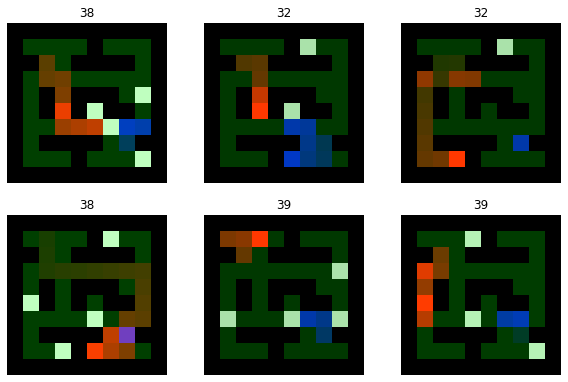

In [215]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [216]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # layers.Conv2D(16, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dense(num_classes)
])

In [217]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [218]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 10, 10, 32)        896       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 5, 5, 32)          18464     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 64)        

In [219]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
14/14 [==============================] - 1s 43ms/step - loss: 1.6309 - accuracy: 0.2677 - val_loss: 1.5412 - val_accuracy: 0.4550
Epoch 2/50
14/14 [==============================] - 0s 26ms/step - loss: 1.4700 - accuracy: 0.4328 - val_loss: 1.3735 - val_accuracy: 0.4687
Epoch 3/50
14/14 [==============================] - 0s 25ms/step - loss: 1.3450 - accuracy: 0.4823 - val_loss: 1.3567 - val_accuracy: 0.4768
Epoch 4/50
14/14 [==============================] - 0s 26ms/step - loss: 1.2584 - accuracy: 0.5283 - val_loss: 1.2832 - val_accuracy: 0.4877
Epoch 5/50
14/14 [==============================] - 0s 25ms/step - loss: 1.1593 - accuracy: 0.5861 - val_loss: 1.2253 - val_accuracy: 0.5341
Epoch 6/50
14/14 [==============================] - 0s 26ms/step - loss: 1.0730 - accuracy: 0.6156 - val_loss: 1.2096 - val_accuracy: 0.5504
Epoch 7/50
14/14 [==============================] - 0s 26ms/step - loss: 1.0194 - accuracy: 0.6309 - val_loss: 1.1676 - val_accuracy: 0.5722
Epoch 8/50
14

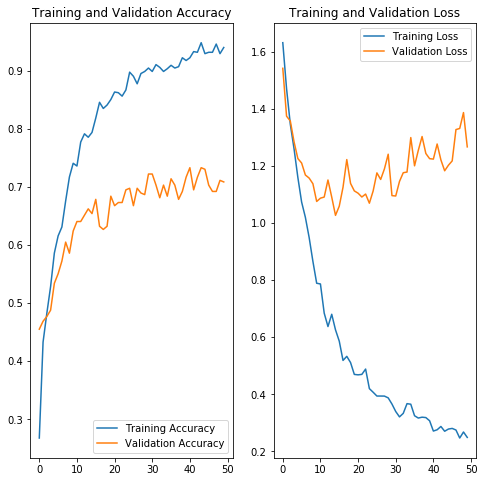

In [220]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [221]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 7ms/step - loss: 1.2661 - accuracy: 0.7084
Test accuracy : 0.7084468603134155


In [222]:
# Save the entire model as a SavedModel.
model.save('./data/humanModel/mode_v0')

INFO:tensorflow:Assets written to: ./data/humanModel/mode_v0\assets


In [223]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [224]:
sunflower_path = "./data/humanModel/imagesDatabase_split/val/39/-Mi--4ao5TjCt9Oht513_10.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 39 with a 99.68 percent confidence.
